In [1]:
#vibo: ПРИВЕТ! БУДУ ОЧЕНЬ БЛАГОДАРЕН ЗА ЛЮБОЙ ФИДБЭК ПО МОЕЙ РАБОТЕ В ТЕЛЕГРАММ @vibo21 или E-MAIL: vv.bo@ya.ru 
#vibo: stepik.org User ID: 56089805

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.







In [2]:
#vibo: импортируем библиотеки
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [3]:
#vibo: создаем датасет из sklearn.dataset, X - оъекты, y - метки классов
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

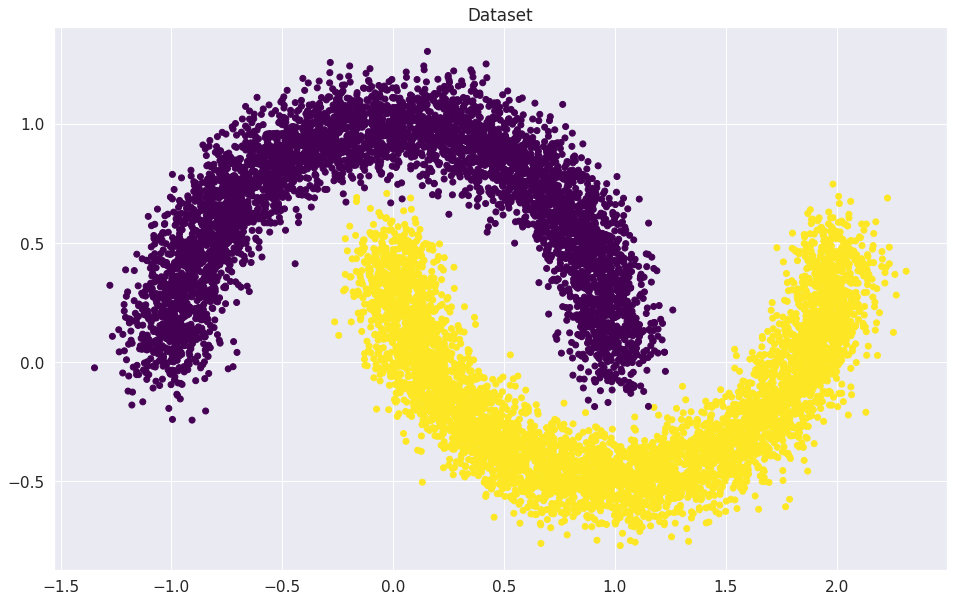

In [4]:
#vibo: визуализируем датасет
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [5]:
#vibo: делим датасет на обучающую и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [6]:
#vibo: заданы два признака и их метки (0 и 1), выведем данные по двум первым объектам на обучающей выборке
print(X_train[0:2])
print(y_train[0:2])

[[ 0.50202001 -0.33758011]
 [-0.02001968  0.239079  ]]
[1 1]


In [7]:
#vibo: при делении датасета по умолчания на тестовую выборку приходить 0.25, проверяем
print('X_train: {}, y_train: {}\nX_val: {}, y_val: {}'.format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

X_train: (7500, 2), y_train: (7500,)
X_val: (2500, 2), y_val: (2500,)


### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [8]:
#vibo: создаем тензоры с обучающими и тестовыми(валидационными) данными, по условию тип - float32
X_train_t = torch.from_numpy(X_train).float()  # YOUR CODE GOES HERE
y_train_t = torch.from_numpy(y_train).float()  # YOUR CODE GOES HERE
X_val_t = torch.from_numpy(X_val).float() # YOUR CODE GOES HERE
y_val_t = torch.from_numpy(y_val).float() # YOUR CODE GOES HERE

In [9]:
#vibo: проверяем размер и тип тензора для обучающей и валидационной выборки
print(X_train_t.dtype, X_train_t.shape, y_train_t.dtype, y_train_t.shape)
print(X_val.dtype, X_val_t.shape, y_val_t.dtype, y_val_t.shape)

torch.float32 torch.Size([7500, 2]) torch.float32 torch.Size([7500])
float64 torch.Size([2500, 2]) torch.float32 torch.Size([2500])


In [10]:
#vibo: посмотрим на данные для обучения
X_train_t

tensor([[ 0.5020, -0.3376],
        [-0.0200,  0.2391],
        [ 0.5703,  0.8117],
        ...,
        [ 0.3216, -0.3567],
        [ 2.0134,  0.0323],
        [ 0.1791,  0.9310]])

In [11]:
#vibo: выведем правильные метки классов на обучающей выборке
y_train_t

tensor([1., 1., 0.,  ..., 1., 1., 0.])

Создаем `Dataset` и `DataLoader`. 

In [21]:
#vibo: создаем TensorDataset (загружает каждый объект по отдельности) для обучающей выборки
train_dataset = TensorDataset(X_train_t, y_train_t)
#vibo: создаем TensorDataset (загружает каждый объект по отдельности) для валидационной выборки
val_dataset = TensorDataset(X_val_t, y_val_t)

#vibo: создаем DataLoader (группирует объекты в батчи) для обучающей выборки
train_dataloader = DataLoader(train_dataset, batch_size=128)
#vibo: создаем DataLoader (группирует объекты в батчи) для валидационной выборки
val_dataloader = DataLoader(val_dataset, batch_size=128)

In [22]:
#vibo: проверяем первый объект из обучающей выборки
for a, b in train_dataset:
    print(a, b)
    break

tensor([ 0.5020, -0.3376]) tensor(1.)


In [23]:
#vibo: проверяем размер первого батча на обучающей выборке
for a, b in train_dataloader:
    print(a.shape, b.shape)
    break

torch.Size([128, 2]) torch.Size([128])


## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [24]:
#vibo: сделаем собственный класс LinearRegression и отнаследуем его от nn.Module
class LinearRegression(nn.Module):
    #vibo: переопределяем конструктор - метод, который вызывается в первую очередь при создании собственного класса
    #vibo: первый метод __init__, у которого первый аргумент всегда self (указатель на объект с которым мы конкрено работаем)
    #vibo: далее аргументы - количество параметров, а также bias 
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        #vibo: вызываем метод super() и от него вызываем __init__, после чего будем добавлять новые свойства
        super().__init__()
        #vibo: уточняем параметр weights, инициализируем произвольные веса модели через torch.randn
        #vibo: добавляем weights в nn.Parameter, для возможности последующего отображения 
        self.weights = nn.Parameter(torch.randn(in_features, out_features)) # YOUR CODE GOES HERE
        
        #vibo: уточняем параметр bias, инициализируем произвольный bais через torch.randn
        self.bias = bias
        if bias:
            #vibo: добавляем bias в nn.Parameter, для возможности последующего отображения
            self.bias_term = nn.Parameter(torch.randn(1, out_features))# YOUR CODE GOES HERE

    #vibo: уточняем метод forward-pass
    def forward(self, x):
        #vibo: перемножаем матрицу с объектами на веса модели
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            #vibo: прибавляем к полученному значению произведения XW bias
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [25]:
#vibo: задаем модель
linear_regression = LinearRegression(2, 1)
#vibo: задаем функцию ошибки (функцию потерь)
loss_function = nn.BCEWithLogitsLoss()
#vibo: задаем оптимизатор, который минимизирует функцию потерь с шагом обучения 0.05
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [26]:
#YOUR CODE
#vibo: выведем обучаемые параметры у получившейся модели используя parameters(), всего их должно быть 3, проверяем
for parameter in linear_regression.parameters():
    print(parameter.data)

tensor([[-0.0802],
        [-0.0790]])
tensor([[-1.0333]])


In [27]:
#vibo: или так, обучаемых параметров 3
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-0.0802],
         [-0.0790]], requires_grad=True),
 Parameter containing:
 tensor([[-1.0333]], requires_grad=True)]

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [28]:
#vibo: задаем ограничение на изменеие весов модели
tol = 1e-3
#vibo: создаем список для последующей визуализации ошибки
losses = []
#vibo: задаем максимальное число эпох (сколько раз модель должна обучиться на всем обучающем датасете)
max_epochs = 100
#vibo: инициализируем нулевые веса модели, копируя размерность матрицы через torch.zeros_like
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
#vibo: начинаем итерироваться по датасету с заданным максимум эпох 100 и ограничением на изменение весов 0.001
for epoch in range(max_epochs):
    #vibo: зашли в эпоху, итерируемся по батчам из созданного train_dataloader, batch_size=128
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        #vibo: обуляем градиенты модели
        optimizer.zero_grad()
        #vibo: получаем логиты после применения созданной модели 
        outp = linear_regression(X_batch).view(-1) # YOUR CODE. Use linear_regression to get outputs
        #vibo: по предсказаниям и истиным меткам класса считаем loss (loss_function выше задана как nn.BCEWithLogitsLoss)
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        #vibo: вычисляем градиенты
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        #vibo: делаем шаг градиентного спуска, выше оптимайзер задан как torch.optim.SGD
        optimizer.step()
        #vibo: считаем вероятность через sigmoid от полученных логитов
        probabilities = F.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        #vibo в случае сходимости выходим из цикла
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8828125
Iteration: 400
Batch accuracy: 0.859375
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125

Iteration: 759.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 759

### Визуализируем результаты

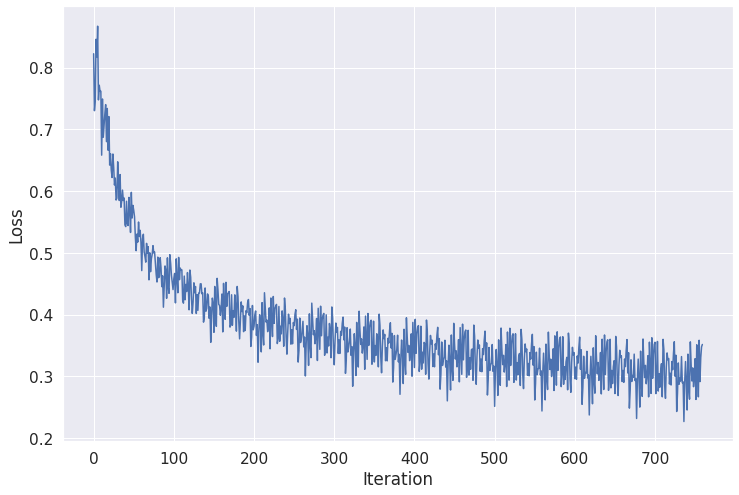

In [30]:
#vibo: для визуализации сходимости, строим график ошибки от числа итераций
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

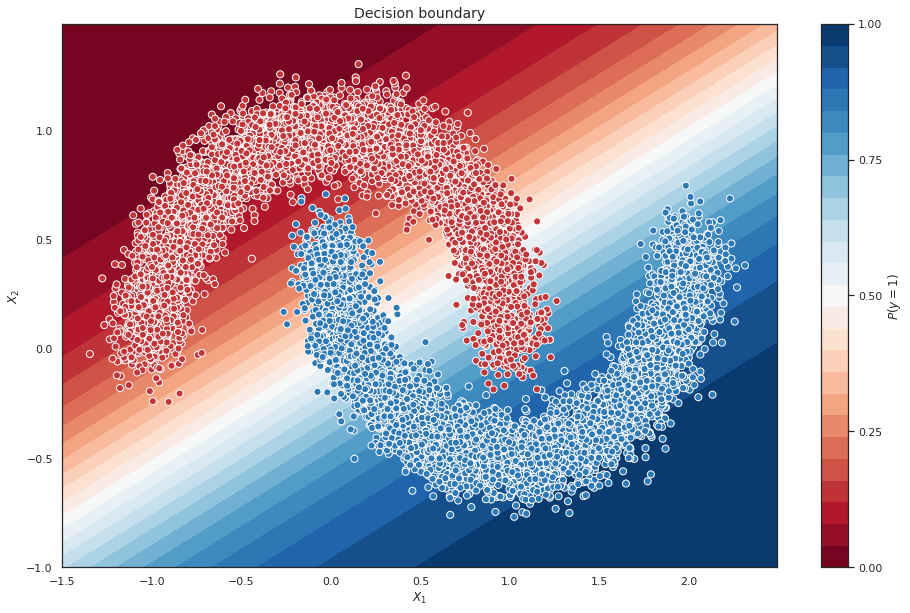

In [31]:
#vibo: красивая визуализация от DLS калассификации объектов с линиями уверенности классификации модели 
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [32]:
#vibo: выведем параметры у обученной модели используя parameters()
for parameter in linear_regression.parameters():
    print(parameter.data)

tensor([[ 1.3374],
        [-2.6283]])
tensor([[-0.0864]])


In [33]:
#vibo: отключаем расчет градиента
@torch.no_grad()
#vibo: реализуем функцию predict с двумя параметрами
#vibo: dataloader у нас будет уже val_dataloader, а модель linear_regression(x_batch)
def predict(dataloader, model):
    #vibo: для отключения расчета градиента (model.eval() идет в паре с @torch.no_grad())
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        #vibo: получаем логиты после применения созданной модели 
        outp = model(x_batch)
        #vibo: считаем вероятность сигмоид от полученных логитов
        probabilities = torch.sigmoid(outp)

        #vibo: вводим порог бинаризации для итоговых предсказаний в виде 1 и 0
        preds = (probabilities > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [34]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
#vibo: рассчитаем точность классификации модели через accuracy_score 
#vibo: в качестве аргументов берем предсказания и правильные ответы на валидационной выборке
accuracy_score(predict(val_dataloader, linear_regression), y_val_t)

0.8596

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8556

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [79]:
#import os
#vibo: загружаем необходимые библиотеки
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
import torch.nn as nn
from torch.nn.functional import cross_entropy
from torchsummary import summary

#vibo: создаем трансформер для последующего преобразования картинок
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
#vibo: создаем TensorDataset (загружает каждый объект по отдельности) для обучающей выборки
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
#vibo: создаем TensorDataset (загружает каждый объект по отдельности) для валидационной выборки
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

#vibo: создаем DataLoader (группирует объекты в батчи) для обучающей выборки, размер батча взял - 128
#vibo: shuffle=True для обучения(хорошая практика, нейросеть не обучится на один последний класс)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)  # YOUR CODE GOES HERE
#vibo: создаем DataLoader (группирует объекты в батчи) для валидационной выборки, размер батча взял - 128
#vibo: shuffle=False для теста (перемешивание случайное и тогда не будем знать какое изображение пошло на вход)
valid_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2) # YOUR CODE GOES HERE

In [81]:
#vibo: проверим обучающую выборку с помощью метода dataset.train_data
#vibo: в обучающей выборке 60000 объектов 28х28 пикселей (черно-белые, третьей размерности нет, она равна 1)
train_dataloader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [83]:
#vibo: проверим валидационную выборку с помощью метода dataset.train_data
#vibo: в тестовой выборке 10000 объектов 28х28 пикселей (черно-белые, третьей размерности нет, она равна 1)
valid_dataloader.dataset.test_data.shape

torch.Size([10000, 28, 28])

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [84]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).

In [85]:
#vibo: введем переменную для передачи функции активации в линейный слой аргументом
activation = nn.ELU()

#vibo: создаем модель с использованием API самого высокого уровня (Sequential)
model = nn.Sequential(
    #vibo: уплощение матрицы в вектор через nn.Flatten
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    #vibo: первый скрытый линейный слой - на вход features = 28*28, на выходе 128 нейрона + функция активации
    nn.Linear(784, 128),
    activation,
    #vibo: второй скрытый линейный слой - на вход 128 нейронов, на выходе 128 нейрона + функция активации
    nn.Linear(128, 128),
    activation,
    #vibo: выходной линейный слой - на вход 128 нейронов, на выходе classes = 10
    nn.Linear(128, 10)
)

In [86]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [87]:
#vibo: задаем функцию ошибки (функцию потерь) - кросс-энтропию
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
#vibo: задаем оптимизатор (Adam), который минимизирует функцию потерь, шаг обучения по умолчанию
optimizer = torch.optim.Adam(model.parameters())
#vibo: создаем словать loaders, будет использован ниже в цикле обучения
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [88]:
#vibo: проверяем доступность GPU, если нет - считаем на CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [89]:
#vibo: задаем максимальное количество эпох (сколько раз будем обучаться на всем датасете, обучающей выборке)
max_epochs = 10
#vibo: создаем словарь с точностью классификации для обучающей и валидационной выборки
accuracy = {"train": [], "valid": []}
#vibo: итерируемся по датасету с заданным количеством эпох
for epoch in range(max_epochs):
    #vibo: зашли в одну эпоху
    #vibo: итерируемся по dataloader для train / valid, словать loaders задан выше
    for k, dataloader in loaders.items():
        #vibo: зашли в один dataloader
        #vibo: вводим переменные для подсчета количества пройденных эпох
        epoch_correct = 0
        epoch_all = 0
        #vibo: итерируемся по объектам в одном dataloader, т.к. используем SGD - берем батчи заданного размера
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                #vibo: переводим модель в режим train
                model.train()
                #vibo: обнуляем градиенты модели
                optimizer.zero_grad()
                #vibo: считаем выходы ('логиты') модели
                outp = model(x_batch)
                
                '''
                #vibo: считаем "лосс" для логистической регрессии (выход модели и истинные ответы на обучающей выборке)
                #vibo: функция потерь задана выше через nn.CrossEntropyLoss()
                loss = criterion(outp, y_batch)
                #vibo: считаем градиенты
                loss.backward()
                #vibo: делаем шаг градиентного спуска
                optimizer.step()
                '''

            #vibo: переходим к оценке по валидационной выборке
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                #vibo: переводим модель в режим test/eval
                model.eval()
                #vibo: НЕ считаем градиенты
                with torch.no_grad():
                    #vibo: считаем выходы ('логиты') по обученной модели
                    outp = model(x_batch)
            
            #vibo: переходим к расчету метрик
            
            preds = outp.argmax(-1)
            #vibo: считаем число правильных предсказаний в текущем батче
            correct = (preds == y_batch).sum()  # YOUR CODE GOES HERE
            #vibo: число объектов в батче
            all = len(x_batch)  # YOUR CODE GOES HERE
            #vibo: суммируем число правльных предсказаний по всей эпохе
            epoch_correct += correct.item()
            #vibo: суммируем число объектов  по всей эпохе
            epoch_all += all

            if k == "train":
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                #vibo: считаем "лосс" для логистической регрессии (выход модели и истинные ответы на обучающей выборке)
                #vibo: функция потерь задана выше через nn.CrossEntropyLoss()                
                loss = criterion(outp, y_batch)
                #vibo: считаем градиенты
                loss.backward()
                #vibo: делаем шаг градиентного спуска
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.88725
Loader: valid. Accuracy: 0.9396
Epoch: 2
Loader: train. Accuracy: 0.9490666666666666
Loader: valid. Accuracy: 0.9576
Epoch: 3
Loader: train. Accuracy: 0.9636166666666667
Loader: valid. Accuracy: 0.9627
Epoch: 4
Loader: train. Accuracy: 0.9720333333333333
Loader: valid. Accuracy: 0.9698
Epoch: 5
Loader: train. Accuracy: 0.9752
Loader: valid. Accuracy: 0.9677
Epoch: 6
Loader: train. Accuracy: 0.9790166666666666
Loader: valid. Accuracy: 0.971
Epoch: 7
Loader: train. Accuracy: 0.98195
Loader: valid. Accuracy: 0.9748
Epoch: 8
Loader: train. Accuracy: 0.9846166666666667
Loader: valid. Accuracy: 0.9769
Epoch: 9
Loader: train. Accuracy: 0.9844833333333334
Loader: valid. Accuracy: 0.9763
Epoch: 10
Loader: train. Accuracy: 0.9875833333333334
Loader: valid. Accuracy: 0.9771


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [90]:
#vibo: итоговая оценка точности прогнозирования модели на валидационной выборке с функцией активации ELU
elu_accuracy = accuracy["valid"]
print('elu_accuracy', elu_accuracy)

elu_accuracy [0.9396, 0.9576, 0.9627, 0.9698, 0.9677, 0.971, 0.9748, 0.9769, 0.9763, 0.9771]


In [91]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

#vibo: делаем функцию для тестирования разных функций активации
def test_activation_function(activation):
    #YOUR CODE

    #vibo: создаем модель с использованием API самого высокого уровня (Sequential)
    model = nn.Sequential(
    #vibo: уплощение матрицы в вектор через nn.Flatten
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    #vibo: первый скрытый линейный слой - на вход features = 28*28, на выходе 128 нейрона + активация
    nn.Linear(784, 128),
    activation,
    #vibo: второй скрытый линейный слой - на вход 128 нейронов, на выходе 128 нейрона + актиация
    nn.Linear(128, 128),
    activation,
    #vibo: выходной линейный слой - на вход 128 нейронов, на выходе classes = 10
    nn.Linear(128, 10)
)

    #vibo: задаем функцию ошибки (функцию потерь) - кросс-энтропию
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    #vibo: задаем оптимизатор (Adam), который минимизирует функцию потерь, шаг обучения по умолчанию
    optimizer = torch.optim.Adam(model.parameters())
    #vibo: создаем словать loaders, будет использован ниже в цикле обучения
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    #vibo: проверяем доступность GPU, если нет - считаем на CPU
    device = "cuda" if torch.cuda.is_available() else "cpu"

    #vibo: задаем максимальное количество эпох (сколько раз будем обучаться на всем датасете, обучающей выборке)
    max_epochs = 10
    #vibo: создаем словарь с точностью классификации для обучающей и валидационной выборки
    accuracy = {"train": [], "valid": []}
    #vibo: итерируемся по датасету с заданным количеством эпох
    for epoch in range(max_epochs):
        #vibo: зашли в одну эпоху
        #vibo: итерируемся по dataloader для train / valid, словать loaders задан выше
        for k, dataloader in loaders.items():
            #vibo: зашли в один dataloader
            #vibo: вводим переменные для подсчета количества пройденных эпох
            epoch_correct = 0
            epoch_all = 0
            #vibo: итерируемся по объектам в одном dataloader, т.к. используем SGD - берем батчи заданного размера
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    #vibo: переводим модель в режим train
                    model.train()
                    #vibo: обнуляем градиенты модели
                    optimizer.zero_grad()
                    #vibo: считаем выходы ('логиты') модели
                    outp = model(x_batch)
                    
                #vibo: переходим к оценке по валидационной выборке
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    #vibo: переводим модель в режим test/eval
                    model.eval()
                    #vibo: НЕ считаем градиенты
                    with torch.no_grad():
                        #vibo: считаем выходы ('логиты') по обученной модели
                        outp = model(x_batch)
                
                #vibo: переходим к расчету метрик
                
                preds = outp.argmax(-1)
                #vibo: считаем число правильных предсказаний в текущем батче
                correct = (preds == y_batch).sum()  # YOUR CODE GOES HERE
                #vibo: число объектов в батче
                all = len(x_batch)  # YOUR CODE GOES HERE
                #vibo: суммируем число правльных предсказаний по всей эпохе
                epoch_correct += correct.item()
                #vibo: суммируем число объектов  по всей эпохе
                epoch_all += all

                if k == "train":
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    #vibo: считаем "лосс" для логистической регрессии (выход модели и истинные ответы на обучающей выборке)
                    #vibo: функция потерь задана выше через nn.CrossEntropyLoss()                
                    loss = criterion(outp, y_batch)
                    #vibo: считаем градиенты
                    loss.backward()
                    #vibo: делаем шаг градиентного спуска
                    optimizer.step()
                
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy["valid"]

In [92]:
#vibo: проверяем точность классификации по валидационной выборке без указания функции активации
print('Start learning whith No activation')
plain_accuracy = test_activation_function(Identical())
print('Finish learning whith No activation')
print('plain_accuracy:', plain_accuracy)

#vibo: проверяем точность классификации по валидационной выборке с ReLU
print('Start learning whith ReLU activation')
relu_accuracy = test_activation_function(nn.ReLU()) #YOUR CODE
print('Finish learning whith ReLU activation')
print('relu_accuracy:', relu_accuracy)

#vibo: проверяем точность классификации по валидационной выборке с LeakyReLU
print('Start learning whith LeakyReLU activation')
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU()) #YOUR CODE
print('Finish learning whith LeakyReLU activation')
print('leaky_relu_accuracy', leaky_relu_accuracy)

Start learning whith No activation
Epoch: 1
Loader: train. Accuracy: 0.86935
Loader: valid. Accuracy: 0.9098
Epoch: 2
Loader: train. Accuracy: 0.9023
Loader: valid. Accuracy: 0.9057
Epoch: 3
Loader: train. Accuracy: 0.90885
Loader: valid. Accuracy: 0.9149
Epoch: 4
Loader: train. Accuracy: 0.9096
Loader: valid. Accuracy: 0.9136
Epoch: 5
Loader: train. Accuracy: 0.90985
Loader: valid. Accuracy: 0.916
Epoch: 6
Loader: train. Accuracy: 0.91255
Loader: valid. Accuracy: 0.9079
Epoch: 7
Loader: train. Accuracy: 0.91535
Loader: valid. Accuracy: 0.9144
Epoch: 8
Loader: train. Accuracy: 0.9152333333333333
Loader: valid. Accuracy: 0.9137
Epoch: 9
Loader: train. Accuracy: 0.9157
Loader: valid. Accuracy: 0.918
Epoch: 10
Loader: train. Accuracy: 0.9157166666666666
Loader: valid. Accuracy: 0.9183
Finish learning whith No activation
plain_accuracy: [0.9098, 0.9057, 0.9149, 0.9136, 0.916, 0.9079, 0.9144, 0.9137, 0.918, 0.9183]
Start learning whith ReLU activation
Epoch: 1
Loader: train. Accuracy: 0.874

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

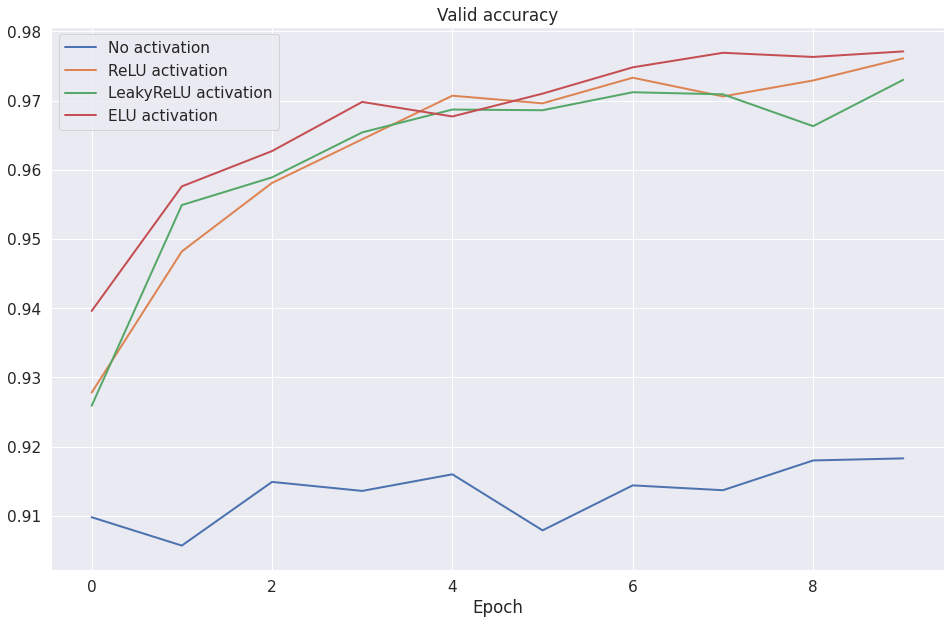

In [93]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

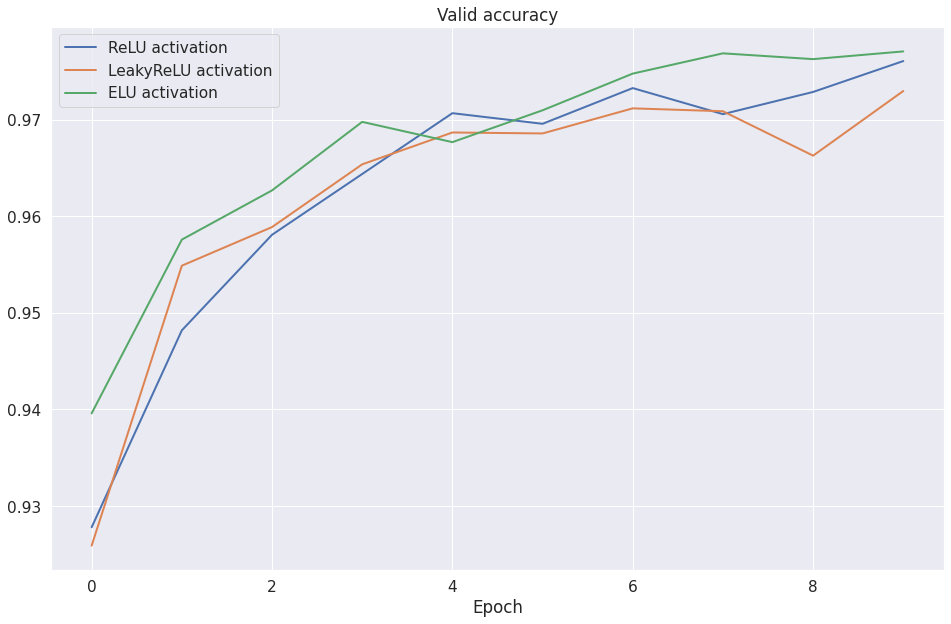

In [94]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [95]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-17 12:05:50--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-17 12:05:51--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.06s   

2021-11-17 12:05:51 (838 KB/s) - ‘sample_photo.jpg’ saved [49337/4

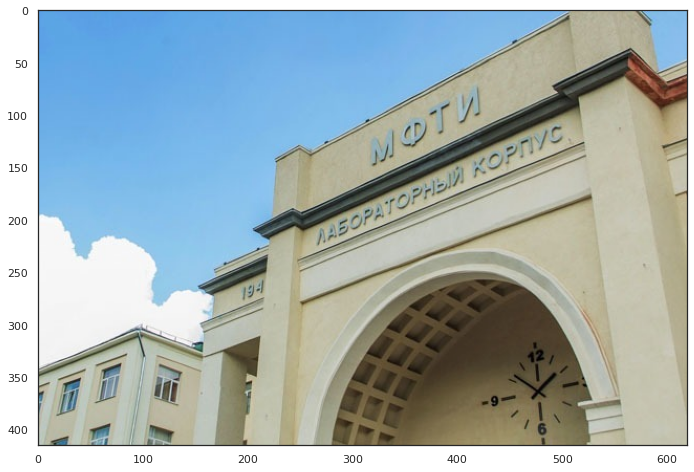

In [96]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [97]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


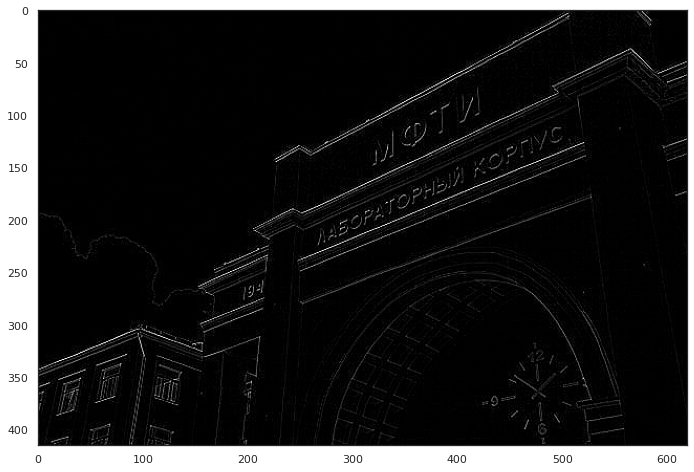

In [98]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** A3, Б5, В4, Г6, Д2, Е1

In [99]:
#vibo: правильный ответ A3, Б5, В4, Г6, Д2, Е1
'''
Б) - 5 - Выделение горизонтальных границ
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]

В) - 4 - Выделение вертикальных границ
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]

'''

'\nБ) - 5 - Выделение горизонтальных границ\n[0, 1, 0],\n[0, -2, 0],\n[0, 1, 0]\n\nВ) - 4 - Выделение вертикальных границ\n[0, 0, 0],\n[1, -2, 1],\n[0, 0, 0]\n\n'

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.



In [100]:
#vibo: по заданию необходимо создать модель следующего уровня API - путем наследования от nn.Module
#vibo: создаем класс LeNet путем наследования от nn.Module
class LeNet(nn.Module):
    def __init__(self):
        #vibo: вызываем конструктора предка
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        #self.conv1 = nn.Conv2d(1, 6, 3)

        #vibo: первый сверточный слой conv1 (Conv Layers)
        '''
        #vibo: in_channels=1 - число входных каналов, т.к. картинка MNIST одноцветная (черно/белая)
               out_channels=6 - количество сверток, которые хотим применить из условия задачи
               kernel_size=3 - размерность окна 3х3
        '''
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        #vibo: делаем первый MaxPooling (размер окна 2х2, шаг окна свертки по умолчанию)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        #vibo: второй сверточный слой conv2 (Conv Layers)
        #vibo: in_channels=6 по выходу с предыдущего слоя, out_channels=16 по условию задачи
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3) #YOUR CODE
        #vibo: делаем второй MaxPooling (размер окна 2х2, шаг окна свертки по умолчанию)
        self.pool2 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
             
        #vibo: полносвязный слой с 120 нейронами и активацией ReLU
        #vibo: размерность входного слоя (5х5х16), выходного - 120 по условию задачи 
        self.fc1 = nn.Linear(5 * 5 * 16, 120) #YOUR CODE  
        #vibo: полносвязный слой с 84 нейронами и активацией ReLU
        self.fc2 = nn.Linear(120, 84) #YOUR CODE
        #vibo: выходной слой из 10 нейронов
        self.fc3 = nn.Linear(84, 10) #YOUR CODE

    def forward(self, x):
        #vibo: раскоментировать/закоментировать строчку, чтобы понять какая размерность тензора
        #print(x.shape) #vibo: torch.Size([2, 1, 28, 28])
        
        #vibo: применяем первый сверточный слой, нелинейность relu, первый pooling
        x = self.pool1(F.relu(self.conv1(x))) #YOUR CODE. Apply layers created in __init__.
        #print(x.shape) #vibo: torch.Size([2, 6, 13, 13])
        
        #vibo: применяем второй сверточный слой, нелинейность relu, второй pooling
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape) #vibo: torch.Size([2, 16, 5, 5])
        
        #vibo: на выходе с предыдущего слоя имеем четырехмерный тензор, где первое значение batch-size
        #vibo: хотим сделать уплощение, для этого применяем метод view
        #vibo: передаем размерность, которую хотим получить 5*5*16 (расчетная, см. выше итог print(x.shape))
        #vibo: ставим -1, т.к. хотим, чтобы первая размерность остается неизменной
        #x = x.view(-1, 5 * 5 * 16)

        #vibo: можно и через flatten
        x = x.flatten(start_dim=1)

        #print(x.shape) #vibo: torch.Size([2, 400])

        #vibo: применяем линейный слой fc1, нелинейность
        x = F.relu(self.fc1(x))
        #print(x.shape) #vibo: torch.Size([2, 120])

        #vibo: применяем второй слой fc2, нелинейность
        x = F.relu(self.fc2(x))
        #print(x.shape) #vibo: torch.Size([2, 84])

        #vibo: третий слой
        x = self.fc3(x)
        #print(x.shape) #vibo: torch.Size([2, 10])

        return x

In [101]:
#vibo: сommunity план DL JB к большому сожалению не предоставляет GPU
device = "cpu"

#vibo: задаем модель
model = LeNet().to(device)
#vibo: задаем функцию ошибки (функцию потерь) - кросс-энтропию
criterion = nn.CrossEntropyLoss()
#vibo: задаем оптимизатор (Adam), который минимизирует функцию потерь, шаг обучения по умолчанию
optimizer = torch.optim.Adam(model.parameters())
#vibo: создаем словать loaders, будет использован ниже в цикле обучения
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [102]:
#vibo: выведем информацию по слоях созданной модели
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [103]:
#vibo: проверяем размерность слоев 1х28х28 входящая картинка из MNIST и параметры модели
summary(model, (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.29
----------------------------------------------------------------


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [104]:
#<YOUR CODE>

#vibo: задаем максимальное количество эпох (сколько раз будем обучаться на всем датасете, обучающей выборке)
max_epochs = 10
#vibo: создаем словарь с точностью классификации для обучающей и валидационной выборки
accuracy = {"train": [], "valid": []}
#vibo: итерируемся по датасету с заданным количеством эпох
for epoch in range(max_epochs):
    #vibo: зашли в одну эпоху
    #vibo: итерируемся по dataloader для train / valid, словать loaders задан выше
    for k, dataloader in loaders.items():
        #vibo: зашли в один dataloader
        #vibo: вводим переменные для подсчета количества пройденных эпох
        epoch_correct = 0
        epoch_all = 0
        #vibo: итерируемся по объектам в одном dataloader, т.к. используем SGD - берем батчи заданного размера
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                #vibo: переводим модель в режим train
                model.train()
                #vibo: обнуляем градиенты модели
                optimizer.zero_grad()
                #vibo: считаем выходы ('логиты') модели
                outp = model(x_batch)

            #vibo: переходим к оценке по валидационной выборке
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                #vibo: переводим модель в режим test/eval
                model.eval()
                #vibo: НЕ считаем градиенты
                with torch.no_grad():
                    #vibo: считаем выходы ('логиты') по обученной модели
                    outp = model(x_batch)
            
            #vibo: переходим к расчету метрик
            
            preds = outp.argmax(-1)
            #vibo: считаем число правильных предсказаний в текущем батче
            correct = (preds == y_batch).sum()  # YOUR CODE GOES HERE
            #vibo: число объектов в батче
            all = len(x_batch)  # YOUR CODE GOES HERE
            #vibo: суммируем число правльных предсказаний по всей эпохе
            epoch_correct += correct.item()
            #vibo: суммируем число объектов  по всей эпохе
            epoch_all += all
                        
            if k == "train":
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                #vibo: считаем "лосс" для логистической регрессии (выход модели и истинные ответы на обучающей выборке)
                #vibo: функция потерь задана выше через nn.CrossEntropyLoss()                
                loss = criterion(outp, y_batch)
                #vibo: считаем градиенты
                loss.backward()
                #vibo: делаем шаг градиентного спуска
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8796333333333334
Loader: valid. Accuracy: 0.9586
Epoch: 2
Loader: train. Accuracy: 0.9662666666666667
Loader: valid. Accuracy: 0.9733
Epoch: 3
Loader: train. Accuracy: 0.9755166666666667
Loader: valid. Accuracy: 0.98
Epoch: 4
Loader: train. Accuracy: 0.98115
Loader: valid. Accuracy: 0.9827
Epoch: 5
Loader: train. Accuracy: 0.9848166666666667
Loader: valid. Accuracy: 0.9844
Epoch: 6
Loader: train. Accuracy: 0.9872333333333333
Loader: valid. Accuracy: 0.9827
Epoch: 7
Loader: train. Accuracy: 0.9887333333333334
Loader: valid. Accuracy: 0.9854
Epoch: 8
Loader: train. Accuracy: 0.99015
Loader: valid. Accuracy: 0.984
Epoch: 9
Loader: train. Accuracy: 0.99135
Loader: valid. Accuracy: 0.9846
Epoch: 10
Loader: train. Accuracy: 0.9924833333333334
Loader: valid. Accuracy: 0.986


In [105]:
#vibo: точность классификциии изображений датасета MNIST с моделью LeNet, 1998 г.
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.9586, 0.9733, 0.98, 0.9827, 0.9844, 0.9827, 0.9854, 0.984, 0.9846, 0.986]

Сравним с предыдущем пунктом

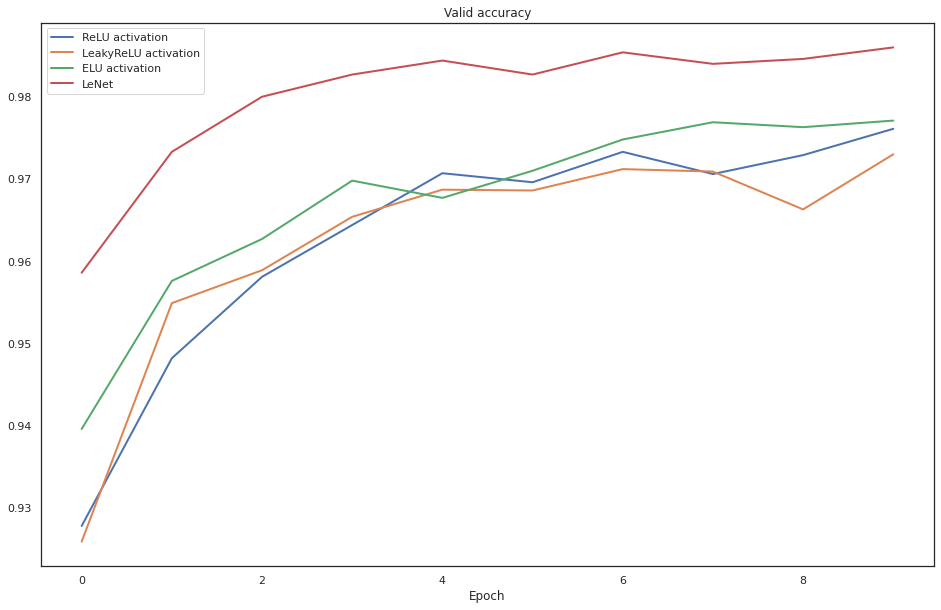

In [106]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

In [107]:
#vibo: БУДУ ОЧЕНЬ БЛАГОДАРЕН ЗА ЛЮБОЙ ФИДБЭК ПО МОЕЙ РАБОТЕ В ТЕЛЕГРАММ @vibo21 или E-MAIL: vv.bo@ya.ru 
#vibo: stepik.org User ID: 56089805